10-run Monte Carlo experiment for each $$\sigma \in \{0.1/2^K|K=1,\ldots 10\}$$ totaling 100 experiments. Used to determine sigma in random walk [Price Estimator Response Dynamics](https://github.com/BlockScience/ZarghamPapers/blob/master/Economic%20Games%20as%20Estimators/Price%20Estimator%20Response%20Dynamics.ipynb)

In [5]:
# import libraries 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns

%matplotlib inline
from bonding_curve_eq import *

## System Initialization

In [6]:
hatch_raise = 100000 # fiat units
hatch_price = .1 #fiat per tokens
theta = .5 #share of funds going to funding pool at launch

R0 = hatch_raise*(1-theta)
S0 = hatch_raise/hatch_price

kappa = 2 # bonding curvature parameter 
V0 = invariant(R0,S0,kappa)
P0 = spot_price(R0, V0, kappa)

dust = 10**-8

## Agent Initialization

In [7]:
#phi for exiting funds
phi = 0

#beta is param for armijo rule
beta = .9

In [8]:
params= {
    'kappa': [kappa],
    'invariant': [V0],
    'dust' : [dust],
    'rule' : ['martin' for r in range(10)],
    'dP' : ['N/A' for r in range(10)],
    'sigma': [.1*(.5**(r+1)) for r in range(10) ],
    'period': ['N/A' for r in range(10)]
}

In [9]:
initial_conditions = {'supply': S0,
                      'price': P0,
                      'reserve': R0,
                      'spot_price': P0,
                      'output_price': P0,
                      }

In [10]:
def set_action(params, step, sL, s):
    
    R = s['reserve']
    S = s['supply']
    V0 = params['invariant']
    P=s['spot_price']
    period = params['period']
    
    if params['rule'] == 'step':
        bump = int((s['timestep'] % int(period/2) == 0))*int(s['timestep']>0)
        sign = -(-1)**int((2*s['timestep']/period))
        new_price = s['price'] + params['dP']*bump*sign
    elif params['rule'] == 'ramp':
        sign = (-1)**int((2*s['timestep']/period))
        new_price = s['price'] + params['dP']*sign
    elif params['rule'] == 'sin':
        new_price = P0 + params['dP']*np.sin(2*np.pi*s['timestep']/period)
    elif params['rule']=='martin' :
        rv = np.random.normal(0, params['sigma'])
        new_price = s['price']+s['price']*rv
    else :
        new_price = s['price']
    
    
    
    if P>new_price: #equiv: pbar(0)>phat_a
        mech = 'burn'
                        
        #approx for burn s.t. p=phat
        #armijo style
        amt = S*(1-params['dust'])

        def pbar(amt):
            output = withdraw(amt, R,S, V0, params['kappa'])

            if not(output[1])>0:
                return np.Infinity
            elif amt==0:
                return P
            else:
                return output[1]

        if amt > params['dust']:
            while pbar(amt)< new_price:
                amt = amt*beta

    else: #equiv pbar(0)<phat_a
        mech = 'bond'
        #approx for buy s.t. p=phat
        #armijo style
        amt = R*(1-params['dust'])

        def pbar(amt):
            output = mint(amt, R,S, V0, params['kappa'])
            
            if not(output[1])>0:
                return 0
            elif amt==0:
                return P
            else:
                return output[1]

        if amt > params['dust']:
            while pbar(amt)> new_price:
                amt = amt*beta

    action = {'mech':mech, 'amt':amt,'pin':new_price ,'pbar':pbar(amt),'posterior':{}}
    
    if action['mech'] == 'bond':

        dS, pbar = mint(amt, R,S, V0, params['kappa'])
        R = R+amt
        S = S+dS
        P = spot_price(R, V0, kappa)

    elif action['mech'] == 'burn':
        dR, pbar = withdraw(amt, R,S, V0, params['kappa'])
        R = R-dR
        S = S-amt
        P = spot_price(R, V0, kappa)

    action['posterior'] = {'S':S, 'R':R,'P':P}
    
    return {'action': action}

In [11]:
def update_S(params, step, sL, s, _input):
    
    action = _input['action']
    S = action['posterior']['S']
    
    key = 'supply'
    value = S
    
    return (key, value)

def update_R(params, step, sL, s, _input):
    
    action = _input['action']
    R = action['posterior']['R']
    
    key = 'reserve'
    value = R
    
    return (key, value)

def update_P(params, step, sL, s, _input):
    
    action = _input['action']
    P = action['posterior']['P']
    
    key = 'spot_price'
    value = P
    
    return (key, value)

def update_Pbar(params, step, sL, s, _input):
    
    action = _input['action']
    pbar = action['pbar']
    
    key = 'output_price'
    value = pbar
    
    return (key, value)

def capture_Pin(params, step, sL, s, _input):
    
    Pin = _input['action']['pin']
    if Pin== 0:
        print(_input['action']) 
    key = 'price'
    value = Pin
    
    return (key, value)

In [12]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The Partial State Update Blocks
partial_state_update_blocks = [
    {
      'policies': {
          'act': set_action,
        },
        'variables': {
            'supply': update_S, 
            'reserve': update_R,
            'spot_price': update_P,
            'output_price': update_Pbar,
            'price': capture_Pin,
        }
    }
]

In [13]:
time_periods_per_run = 4000
monte_carlo_runs = 10

from cadCAD.configuration.utils import config_sim
simulation_parameters = config_sim({
    'T': range(time_periods_per_run),
    'N': monte_carlo_runs,
    'M': params
})

In [14]:
from cadCAD.configuration import append_configs
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
append_configs(
    initial_state=initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters #dict containing simulation parameters
)

[{'N': 10, 'T': range(0, 4000), 'M': {'kappa': 2, 'invariant': 20000000.0, 'dust': 1e-08, 'rule': 'martin', 'dP': 'N/A', 'sigma': 0.05, 'period': 'N/A'}}, {'N': 10, 'T': range(0, 4000), 'M': {'kappa': 2, 'invariant': 20000000.0, 'dust': 1e-08, 'rule': 'martin', 'dP': 'N/A', 'sigma': 0.025, 'period': 'N/A'}}, {'N': 10, 'T': range(0, 4000), 'M': {'kappa': 2, 'invariant': 20000000.0, 'dust': 1e-08, 'rule': 'martin', 'dP': 'N/A', 'sigma': 0.0125, 'period': 'N/A'}}, {'N': 10, 'T': range(0, 4000), 'M': {'kappa': 2, 'invariant': 20000000.0, 'dust': 1e-08, 'rule': 'martin', 'dP': 'N/A', 'sigma': 0.00625, 'period': 'N/A'}}, {'N': 10, 'T': range(0, 4000), 'M': {'kappa': 2, 'invariant': 20000000.0, 'dust': 1e-08, 'rule': 'martin', 'dP': 'N/A', 'sigma': 0.003125, 'period': 'N/A'}}, {'N': 10, 'T': range(0, 4000), 'M': {'kappa': 2, 'invariant': 20000000.0, 'dust': 1e-08, 'rule': 'martin', 'dP': 'N/A', 'sigma': 0.0015625, 'period': 'N/A'}}, {'N': 10, 'T': range(0, 4000), 'M': {'kappa': 2, 'invariant'

In [15]:
from tabulate import tabulate
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs
import pandas as pd

exec_mode = ExecutionMode()
multi_proc_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=multi_proc_ctx, configs=configs)

In [16]:
i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1
    


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x7f18f4a569d0>, <cadCAD.configuration.Configuration object at 0x7f18f4a56c10>, <cadCAD.configuration.Configuration object at 0x7f18f4a56d50>, <cadCAD.configuration.Configuration object at 0x7f18f4a56e90>, <cadCAD.configuration.Configuration object at 0x7f18f4af6a90>, <cadCAD.configuration.Configuration object at 0x7f18f4a5f150>, <cadCAD.configuration.Configuration object at 0x7f18f4a5f290>, <cadCAD.configuration.Configuration object at 0x7f18f4a5f3d0>, <cadCAD.configuration.Configuration object at 0x7f18f4a5f510>, <cadCAD.configuration.Configuration object at 0x7f18f4a5f110>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7f18f4a

In [17]:
experiment_index = 0
results[experiment_index]['result'].price[1]

0.10961220792947979

In [18]:
results[0]['simulation_parameters']['M']

{'kappa': 2,
 'invariant': 20000000.0,
 'dust': 1e-08,
 'rule': 'martin',
 'dP': 'N/A',
 'sigma': 0.05,
 'period': 'N/A'}

In [19]:
def assign_run(df, T = time_periods_per_run):
    temp_df = df.reset_index()
    temp_df["run"] = temp_df['index'].apply(lambda x: int(np.floor(x/(T+1))))
    
    return temp_df.drop("index", axis =1)

In [20]:
def append_parameters(result, experiment_index):
    sim_params = result['simulation_parameters']
    params = sim_params['M']
    frame = result['result']
    frame["experiment_index"] = experiment_index
    for key in params.keys():
        frame[key] = params[key]
        
    return frame

In [21]:
def package_results(results):
    dataframes =  [ assign_run(append_parameters(results[experiment_index],experiment_index)) for experiment_index in range(i)]
    return pd.concat(dataframes)

In [22]:
df = package_results(results)

In [23]:
df.head()

,supply,price,reserve,spot_price,output_price,run,substep,timestep,experiment_index,kappa,invariant,dust,rule,dP,sigma,period
0,1.000000e+06,0.100000,50000.000000,0.100000,0.100000,0,0,0,0,2,20000000.0,1.000000e-08,martin,N/A,0.05,N/A
1,1.177888e+06,0.109612,69371.024256,0.117789,0.108894,0,1,1,0,2,20000000.0,1.000000e-08,martin,N/A,0.05,N/A
2,1.093328e+06,0.113489,59768.283270,0.109333,0.113561,0,1,2,0,2,20000000.0,1.000000e-08,martin,N/A,0.05,N/A
3,1.006117e+06,0.104526,50613.563413,0.100612,0.104972,0,1,3,0,2,20000000.0,1.000000e-08,martin,N/A,0.05,N/A
4,1.139371e+06,0.107767,64908.328525,0.113937,0.107274,0,1,4,0,2,20000000.0,1.000000e-08,martin,N/A,0.05,N/A


In [24]:
df['err'] = df.price-df.spot_price
df['abs_err']= df.err.apply(abs)

In [25]:
gb=df[['timestep','experiment_index','run','abs_err','sigma']].groupby(['run','experiment_index'])

In [26]:
sigs = params['sigma']

In [27]:
sig_data= [df[df.sigma == sig ].abs_err for sig in sigs]

In [28]:
df['rel_err'] = df.abs_err/df.spot_price

In [29]:
sig_data2= [df[df.sigma == sig ].rel_err for sig in sigs]

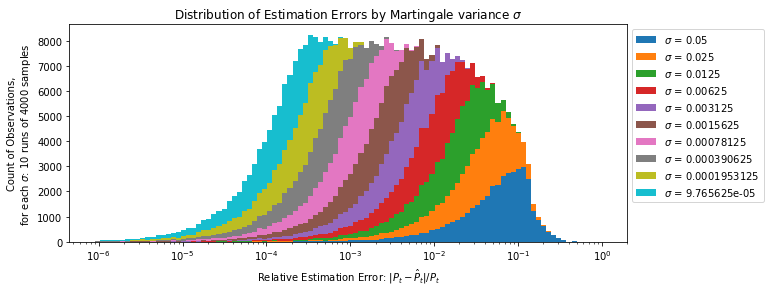

In [30]:
plt.subplots(figsize=(10,4))
plt.hist(sig_data2, bins=[.87**pow for pow in range(100,-1,-1)], stacked=True)
plt.xscale("log")
plt.legend(['$\sigma$ = '+str(st) for st in params['sigma']], bbox_to_anchor=(1, 1), loc='upper left', ncol=1 )

plt.title('Distribution of Estimation Errors by Martingale variance $\sigma$')
plt.ylabel("""Count of Observations,
for each $\sigma$: 10 runs of 4000 samples """)
plt.xlabel('Relative Estimation Error: $|P_t - \hat P_t|/P_t$')
plt.show()

Distribution of relative estimation errors for various sigmas in the random walk.

In [31]:
df['price_pc']=df.price.pct_change()
df['spot_price_pc']=df.spot_price.pct_change()

In [32]:
def response_plot(rdf, title):
    plt.subplots(figsize=(10,6))
    ax1=plt.subplot(2,1,1)
    #rdf[["timestep","spot_price","price"]].plot(x='timestep',ax=ax1)
    rdf[["spot_price","price"]].plot(ax=ax1)
    plt.legend(["spot price (output: $P_t$)", "price sample (input: $\hat P_t$)" ])
    #plt.xlabel("transaction count (time)")
    plt.ylabel("Price, $\hat P_t$, $P_t$")
    plt.title(title+" Response Dynamics")
    ax2=plt.subplot(2,1,2)
    #rdf[["timestep","abs_err"]].plot(x="timestep",ax=ax2,logy=True, color='green')
    rdf[["abs_err"]].plot(ax=ax2,logy=True, color='green')
    plt.legend(["$Error: |P_t-\hat P_t|$" ])
    plt.xlabel("transaction count (time)")
    plt.ylabel("Absolute Value of Estimation Error")
    plt.show()